## Set random seed to get more reproducible result

In [1]:
from numpy.random import seed
seed(2)
from tensorflow.random import set_seed
set_seed(2)

## Import libraries and functions

In [2]:
import os
import matplotlib
import numpy as np
import pandas as pd
from tqdm import trange, tqdm

from expert.src.utils import read_genus_abu, read_labels, load_otlg, zero_weight_unk, parse_otlg, get_dmax
from expert.src.preprocessing import *
from expert.src.model import *
from expert.CLI.CLI_utils import find_pkg_resource as find_expert_resource

from tensorflow.keras.layers import Dense, Dropout, AlphaDropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.initializers import HeUniform, GlorotUniform

## Set hyper-parameters for training process

In [3]:
init = HeUniform(seed=2)
sig_init = GlorotUniform(seed=2)
phylogeny_path = find_expert_resource('resources/phylogeny.csv')
ontology = load_otlg('ontology.pkl')
phylogeny = pd.read_csv(phylogeny_path, index_col=0)
lrreducer = ReduceLROnPlateau(monitor='val_loss', patience=5, min_lr=1e-5, verbose=5, factor=0.1)
stopper = EarlyStopping(monitor='val_loss', patience=15, verbose=5, restore_best_weights=True)
callbacks = [lrreducer, stopper]
phylogeny = pd.read_csv(find_expert_resource('resources/phylogeny.csv'), index_col=0)
optimizer = Adam(lr=1e-3)
metrics = [BinaryAccuracy(name='acc'), AUC(name='AUC')]
loss = BinaryCrossentropy()
epochs = 2000
batch_size = 128
validation_split = 0.1

## Preprocess the data, using EXPERT's command-line API 

In [76]:
%%bash 

expert construct -i microbiomes.txt -o ontology.pkl
for i in {0,1,2,3,4}; do
    expert map --to-otlg -i experiments/exp_$i/QueryMapper.csv.gz -t ontology.pkl -o experiments/exp_$i/QueryLabels.h5;
    expert map --to-otlg -i experiments/exp_$i/SourceMapper.csv.gz -t ontology.pkl -o experiments/exp_$i/SourceLabels.h5;
    ls experiments/exp_$i/QueryCM.tsv.gz > tmp; expert convert -i tmp -o experiments/exp_$i/QueryCM.h5 --in-cm;
    ls experiments/exp_$i/SourceCM.tsv.gz > tmp; expert convert -i tmp -o experiments/exp_$i/SourceCM.h5 --in-cm;
done

Reading microbiome structure...
Generating Ontology...
root
├── root:Diseases
│   ├── root:Diseases:Digestive System Diseases
│   │   ├── root:Diseases:Digestive System Diseases:Gastrointestinal Diseases
│   │   │   └── root:Diseases:Digestive System Diseases:Gastrointestinal Diseases:Intestinal Diseases
│   │   │       ├── root:Diseases:Digestive System Diseases:Gastrointestinal Diseases:Intestinal Diseases:Colonic diseases
│   │   │       │   └── root:Diseases:Digestive System Diseases:Gastrointestinal Diseases:Intestinal Diseases:Colonic diseases:Irritable Bowel Syndrome
│   │   │       └── root:Diseases:Digestive System Diseases:Gastrointestinal Diseases:Intestinal Diseases:Inflammatory Bowel Diseases
│   │   │           ├── root:Diseases:Digestive System Diseases:Gastrointestinal Diseases:Intestinal Diseases:Inflammatory Bowel Diseases:Colitis, Ulcerative
│   │   │           └── root:Diseases:Digestive System Diseases:Gastrointestinal Diseases:Intestinal Diseases:Inflammatory Bowe

100%|██████████| 1/1 [00:37<00:00, 37.25s/it]


In [ ]:
!awk -F ',' '{print $3}'

## Evaluate the model 

In [79]:
%%bash
for i in {0,1,2,3,4}; do
    mkdir running_$i;
    expert train -i experiments/exp_$i/SourceCM.h5 -t ontology.pkl -l experiments/exp_$i/SourceLabels.h5 -o experiments/exp_$i/TrainModel;
    expert search -i experiments/exp_$i/QueryCM.h5 -m experiments/exp_$i/TrainModel -o experiments/exp_$i/SearchResult_Train;
    expert evaluate -i experiments/exp_$i/SearchResult_Train -l experiments/exp_$i/QueryLabels.h5 -o experiments/exp_$i/EvalResult_Train -S 0;

    expert transfer -i experiments/exp_$i/SourceCM.h5 -t ontology.pkl -l experiments/exp_$i/SourceLabels.h5 -o experiments/exp_$i/AdaptModel_ft --finetune --update-statistics;
    expert search -i experiments/exp_$i/QueryCM.h5 -m experiments/exp_$i/AdaptModel_ft -o experiments/exp_$i/SearchResult_Adapt_ft;
    expert evaluate -i experiments/exp_$i/SearchResult_Adapt_ft -l experiments/exp_$i/QueryLabels.h5 -o experiments/exp_$i/EvalResult_Adapt_ft -S 0;

    expert transfer -i experiments/exp_$i/SourceCM.h5 -t ontology.pkl -l experiments/exp_$i/SourceLabels.h5 -o experiments/exp_$i/AdaptModel_ft_human \
            -m /home/chonghui/data2/EXPERT_cases/CRC_progress_ontology/humanModel/model --finetune --update-statistics;
    expert search -i experiments/exp_$i/QueryCM.h5 -m experiments/exp_$i/AdaptModel_ft_human -o experiments/exp_$i/SearchResult_Adapt_ft_human;
    expert evaluate -i experiments/exp_$i/SearchResult_Adapt_ft_human -l experiments/exp_$i/QueryLabels.h5 -o experiments/exp_$i/EvalResult_Adapt_ft_human -S 0;
done

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

mkdir: cannot create directory ‘running_0’: File exists
2020-11-25 16:32:37.914290: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2020-11-25 16:32:37.924047: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2499960000 Hz
2020-11-25 16:32:37.926265: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5606a5628f80 initialized for platform Host (this does not guarantee

In [116]:
overall.T.groupby(by=overall.columns.to_series().apply(lambda x: '-'.join(x.split('-')[0:2]) + '(' + x.split('-')[3] + ')')).mean()

,root:Diseases,root:Health,root:Infections,root:Diseases:Digestive System Diseases,root:Diseases:Hemic and Lymphatic Diseases,root:Infections:Bacterial Infections and Mycoses,root:Diseases:Digestive System Diseases:Gastrointestinal Diseases,root:Diseases:Digestive System Diseases:Liver Diseases,root:Diseases:Hemic and Lymphatic Diseases:Hematologic Diseases,root:Infections:Bacterial Infections and Mycoses:Bacterial Infections,root:Diseases:Digestive System Diseases:Gastrointestinal Diseases:Intestinal Diseases,root:Diseases:Digestive System Diseases:Liver Diseases:Liver Cirrhosis,root:Diseases:Hemic and Lymphatic Diseases:Hematologic Diseases:Hematologic Neoplasms,root:Infections:Bacterial Infections and Mycoses:Bacterial Infections:Gram-Positive Bacterial Infections,root:Diseases:Digestive System Diseases:Gastrointestinal Diseases:Intestinal Diseases:Colonic diseases,root:Diseases:Digestive System Diseases:Gastrointestinal Diseases:Intestinal Diseases:Inflammatory Bowel Diseases,root:Infections:Bacterial Infections and Mycoses:Bacterial Infections:Gram-Positive Bacterial Infections:Clostridium Infections,root:Diseases:Digestive System Diseases:Gastrointestinal Diseases:Intestinal Diseases:Colonic diseases:Irritable Bowel Syndrome,"root:Diseases:Digestive System Diseases:Gastrointestinal Diseases:Intestinal Diseases:Inflammatory Bowel Diseases:Colitis, Ulcerative",root:Diseases:Digestive System Diseases:Gastrointestinal Diseases:Intestinal Diseases:Inflammatory Bowel Diseases:Crohn Disease
F-max(Adapt_ft),0.64226,0.90270,0.52042,0.83706,0.85346,0.66388,0.76082,0.67034,0.79584,0.63586,0.78854,0.68902,0.81016,0.65156,0.41544,0.77190,0.65840,0.62146,0.77776,0.33662
F-max(Adapt_ft_human),0.66772,0.90966,0.46252,0.83718,0.77068,0.63754,0.77808,0.74688,0.74908,0.62154,0.79276,0.75174,0.76336,0.62304,0.53860,0.78508,0.69074,0.55278,0.77806,0.41866
F-max(Train),0.76016,0.92936,0.71978,0.88336,0.81370,0.76602,0.83452,0.83504,0.66102,0.78786,0.84458,0.77726,0.88882,0.79030,0.54566,0.85052,0.81094,0.74350,0.81522,0.40896
ROC-AUC(Adapt_ft),0.85716,0.85568,0.82460,0.78004,0.93166,0.79442,0.70872,0.83266,0.91292,0.78530,0.77822,0.86390,0.91290,0.79140,0.74502,0.72242,0.78234,0.71224,0.74200,0.43508
ROC-AUC(Adapt_ft_human),0.86806,0.86578,0.81204,0.79000,0.85560,0.78622,0.77804,0.86372,0.90250,0.78284,0.79526,0.87074,0.88032,0.78984,0.74526,0.76626,0.81498,0.73154,0.75626,0.62252
ROC-AUC(Train),0.90672,0.90862,0.90032,0.86088,0.88556,0.86146,0.80656,0.92680,0.84470,0.82126,0.83138,0.86734,0.95200,0.83860,0.75868,0.82380,0.83168,0.77948,0.79506,0.54056


In [3]:
matplotlib.rcParams['pdf.fonttype'] = 42

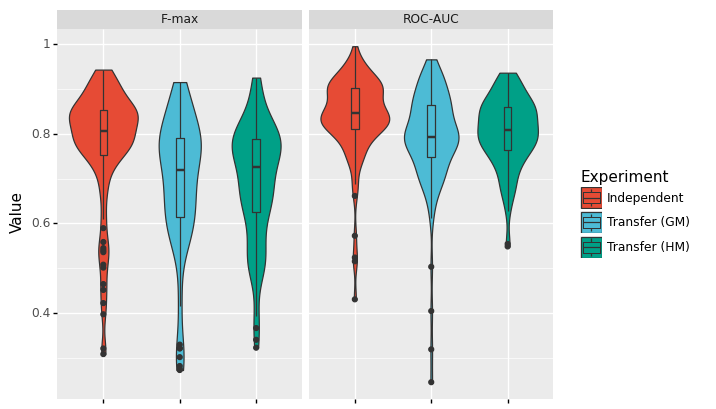

<ggplot: (8753950676700)>


/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 4.8 x 4.8 in image.
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: Figure_performance_across_models.pdf


In [5]:
from plotnine import *

metrics =[pd.read_csv('experiments/exp_{}/EvalResult_{}/overall.csv'.format(i, suffix), index_col=0).rename(columns=lambda x: '{}-exp_{}-{}'.format(x, i, suffix)).dropna()
        for i in range(5) for suffix in ['Train', 'Adapt_ft', 'Adapt_ft_human']]
overall = pd.concat(metrics, axis=1)
overall
overall = overall.reset_index().melt(id_vars=['index'], value_vars=overall.columns.tolist(), var_name='metric').dropna()
overall['Experiment'] = overall['metric'].str.split('-').apply(lambda x: '{}'.format( x[3])).map({'Adapt_ft': 'Transfer (GM)', 'Adapt_ft_human': 'Transfer (HM)', 'Train': 'Independent'})
overall['Metric'] = overall['metric'].str.split('-').apply(lambda x: '{}-{}'.format(x[0], x[1]))

from plotnine import *
plot = (ggplot(overall, aes(x='Experiment', y='value', fill='Experiment'))
         + geom_violin()
         + geom_boxplot(width=0.1)
         + scale_fill_manual(['#E64B35FF','#4DBBD5FF','#00A087FF','#3C5488FF','#F39B7FFF','#8491B4FF','#91D1C2FF'])
         + theme(axis_title_x=element_blank(), axis_text_x=element_blank())
         + xlab('Experiment')
         + ylab('Value')
         + facet_wrap('Metric'))
print(plot)
plot.save('Figure_performance_across_models.pdf', dpi=120, width=4.8, height=4.8)
#plot.save('Figure.png', dpi=120, width=4, height=3)

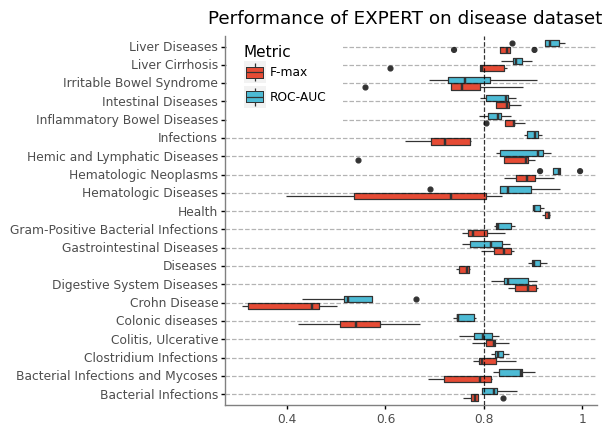

<ggplot: (8753953232381)>


/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 4.8 x 4.8 in image.
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: Figure_Independent_performance.pdf


In [8]:
from plotnine import *

metrics =[pd.read_csv('experiments/exp_{}/EvalResult_{}/overall.csv'.format(i, 'Train'), index_col=0).rename(columns=lambda x: '{}-exp_{}'.format(x, i)).dropna() for i in range(5)]
overall = pd.concat(metrics, axis=1)
overall
overall = overall.reset_index().melt(id_vars=['index'], value_vars=overall.columns.tolist(), var_name='metric').dropna()
overall['Metric'] = overall['metric'].apply(lambda x: '-'.join(x.split('-')[0:2]))
overall = overall.rename(columns={'index': 'Phenotype'}).drop(columns=['metric']).reset_index()
overall['Phenotype'] = overall['Phenotype'].apply(lambda x: x.split(':')[-1])
overall = overall.dropna()
from plotnine import *
import plotnine
plotnine.options.figure_size = (4.8, 4.8)
plot = (ggplot(overall, aes(x='Phenotype', y='value', fill='Metric'))
         + geom_boxplot()
         + scale_fill_manual(['#E64B35FF','#4DBBD5FF','#00A087FF','#3C5488FF','#F39B7FFF','#8491B4FF','#91D1C2FF'])
         + theme(panel_grid_major = element_blank(), panel_grid_minor = element_blank(), panel_background = element_blank(), 
                 legend_position = (0.25, 0.8), axis_title_y=element_blank(), axis_title_x=element_blank(), 
                 axis_line_x = element_line(color="gray", size = 1), axis_line_y = element_line(color="gray", size = 1))
         + geom_vline(xintercept = np.arange(21)/1, linetype='--', alpha=0.3)
         + geom_hline(yintercept = 0.8, linetype='--', alpha=0.8)
         + coord_flip()
         + ggtitle('Performance of EXPERT on disease dataset')
       )
print(plot)
plot.save('Figure_Independent_performance.pdf', dpi=120, width=4.8, height=4.8)

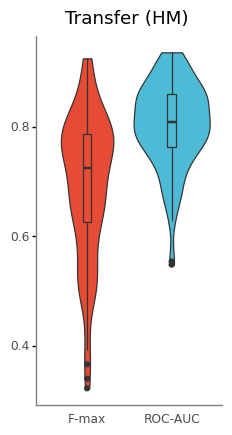

<ggplot: (8753944239595)>


/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 2.4 x 4.8 in image.
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: Figure_Transfer_(HM)_performance.pdf


In [9]:
from plotnine import *

metrics =[pd.read_csv('experiments/exp_{}/EvalResult_{}/overall.csv'.format(i, 'Adapt_ft_human'), index_col=0).rename(columns=lambda x: '{}-exp_{}-{}'.format(x, i, 'Adapt_ft_human')).dropna() for i in range(5)]
overall = pd.concat(metrics, axis=1)

overall = overall.reset_index().melt(id_vars=['index'], value_vars=overall.columns.tolist(), var_name='metric').dropna()
overall['Metric'] = overall['metric'].apply(lambda x: '-'.join(x.split('-')[0:2]))
overall['Experiment'] = overall['metric'].str.split('-').apply(lambda x: '{}'.format(x[3])).map({'Adapt_ft': 'Transfer (GM)', 'Adapt_ft_human': 'Transfer (HM)', 'Train': 'Independent'})
overall = overall.rename(columns={'index': 'Phenotype'}).drop(columns=['metric']).reset_index()
from plotnine import *
import plotnine
plotnine.options.figure_size = (2.4, 4.8)
plot = (ggplot(overall, aes(x='Metric', y='value', fill='Metric'))
         + geom_violin(show_legend=False)
         + geom_boxplot(width=0.1, show_legend=False)
         + scale_fill_manual(['#E64B35FF','#4DBBD5FF','#00A087FF','#3C5488FF','#F39B7FFF','#8491B4FF','#91D1C2FF'])
         + theme(axis_title_y=element_blank())
         + theme(axis_title_x=element_blank())
         + theme(panel_grid_major = element_blank(), panel_grid_minor = element_blank(), panel_background = element_blank(), axis_ticks_major_x=element_blank(),
                 axis_line_x = element_line(color="gray", size = 1), axis_line_y = element_line(color="gray", size = 1))
         + guides(fill=False)
         + ggtitle('Transfer (HM)')
       )
print(plot)
plot.save('Figure_Transfer_(HM)_performance.pdf', dpi=120, width=2.4, height=4.8)